In [20]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.patches as patches
from typing import Tuple, Optional


df = pd.read_csv("plot-dta.csv", parse_dates=["DateTime"])

In [21]:
def add_signal_markers(ax, df: pd.DataFrame, signal_column: str = 'Filtered_Crossover'):
    """Add buy/sell signal markers to the chart."""
    for i, row in df.iterrows():
        if row[signal_column] == 1:  # Bullish
            ax.scatter(i, row['Low'] * 0.999, marker='^', color='green', s=100, zorder=5)
        elif row[signal_column] == -1:  # Bearish
            ax.scatter(i, row['High'] * 1.001, marker='v', color='red', s=100, zorder=5)


In [22]:
def add_sl_tp_boxes(ax, df: pd.DataFrame, signal_column: str = 'Filtered_Crossover'):
    """Add stop loss and take profit boxes to the chart."""
    for i, row in df.iterrows():
        if row[signal_column] != 0 and not pd.isna(row['SL']) and not pd.isna(row['TP']):
            width = 0.8
            color = 'green' if row[signal_column] == 1 else 'red'

            rect = patches.Rectangle(
                (i - width/2, min(row['SL'], row['TP'])),
                width,
                abs(row['TP'] - row['SL']),
                color=color,
                alpha=0.2,
                linewidth=1,
                edgecolor=color
            )
            ax.add_patch(rect)


In [23]:
def plot_enhanced_chart(df: pd.DataFrame, start_idx: Optional[int] = None,
                       end_idx: Optional[int] = None, show_signals: bool = True,
                       show_boxes: bool = True, signal_column: str = 'Filtered_Crossover',
                       figsize: Tuple[int, int] = (16, 10)) -> Tuple:
    """
    Create an enhanced chart with multiple panels and indicators.

    Args:
        df: DataFrame with all indicators
        start_idx: Start index for plotting
        end_idx: End index for plotting
        show_signals: Whether to show crossover signals
        show_boxes: Whether to show SL/TP boxes
        signal_column: Column containing trading signals
        figsize: Figure size tuple

    Returns:
        Tuple of (figure, axes)
    """
    # Slice data if indices provided
    if start_idx is not None:
        df = df.iloc[start_idx:end_idx] if end_idx else df.iloc[start_idx:]

    df = df.copy().reset_index()

    # Prepare additional plots
    addplots = []

    # Moving averages on main panel
    if 'EMA_20' in df.columns:
        addplots.append(mpf.make_addplot(df['EMA_20'], color='orange', width=1))
    if 'EMA_50' in df.columns:
        addplots.append(mpf.make_addplot(df['EMA_50'], color='blue', width=1))
    if 'SMA_200' in df.columns:
        addplots.append(mpf.make_addplot(df['SMA_200'], color='red', width=1))

    # MACD on panel 1
    if 'MACD' in df.columns:
        addplots.append(mpf.make_addplot(df['MACD'], panel=1, color='green', width=1.2))
        addplots.append(mpf.make_addplot(df['MACD_Signal'], panel=1, color='red', width=1.2))
        addplots.append(mpf.make_addplot(df['MACD_Hist'], panel=1, type='bar', color='gray', alpha=0.5))

    # RSI on panel 2
    if 'RSI' in df.columns:
        addplots.append(mpf.make_addplot(df['RSI'], panel=2, color='purple', width=1))
        # RSI reference lines
        rsi_70 = pd.Series([70] * len(df), index=df.index)
        rsi_30 = pd.Series([30] * len(df), index=df.index)
        addplots.append(mpf.make_addplot(rsi_70, panel=2, color='red', linestyle='--', alpha=0.5))
        addplots.append(mpf.make_addplot(rsi_30, panel=2, color='green', linestyle='--', alpha=0.5))

    # Determine panel ratios
    num_panels = 1  # Main price panel
    if 'MACD' in df.columns:
        num_panels += 1
    if 'RSI' in df.columns:
        num_panels += 1

    panel_ratios = [3] + [1] * (num_panels - 1) if num_panels > 1 else None

    # Create the plot
    fig, axes = mpf.plot(
        df.set_index('DateTime'),
        type='candle',
        style='charles',
        volume=False,
        figsize=figsize,
        returnfig=True,
        addplot=addplots if addplots else None,
        title='Enhanced MACD Trading Strategy',
        panel_ratios=panel_ratios,
        tight_layout=True
    )

    main_ax = axes[0] if isinstance(axes, (list, tuple)) else axes

    # Add signal markers
    if show_signals and signal_column in df.columns:
        add_signal_markers(main_ax, df, signal_column)

    # Add SL/TP boxes
    if show_boxes and all(col in df.columns for col in ['SL', 'TP']) and signal_column in df.columns:
        add_sl_tp_boxes(main_ax, df, signal_column)

    return fig, axes

/tmp/ipykernel_1782/4041504966.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle(


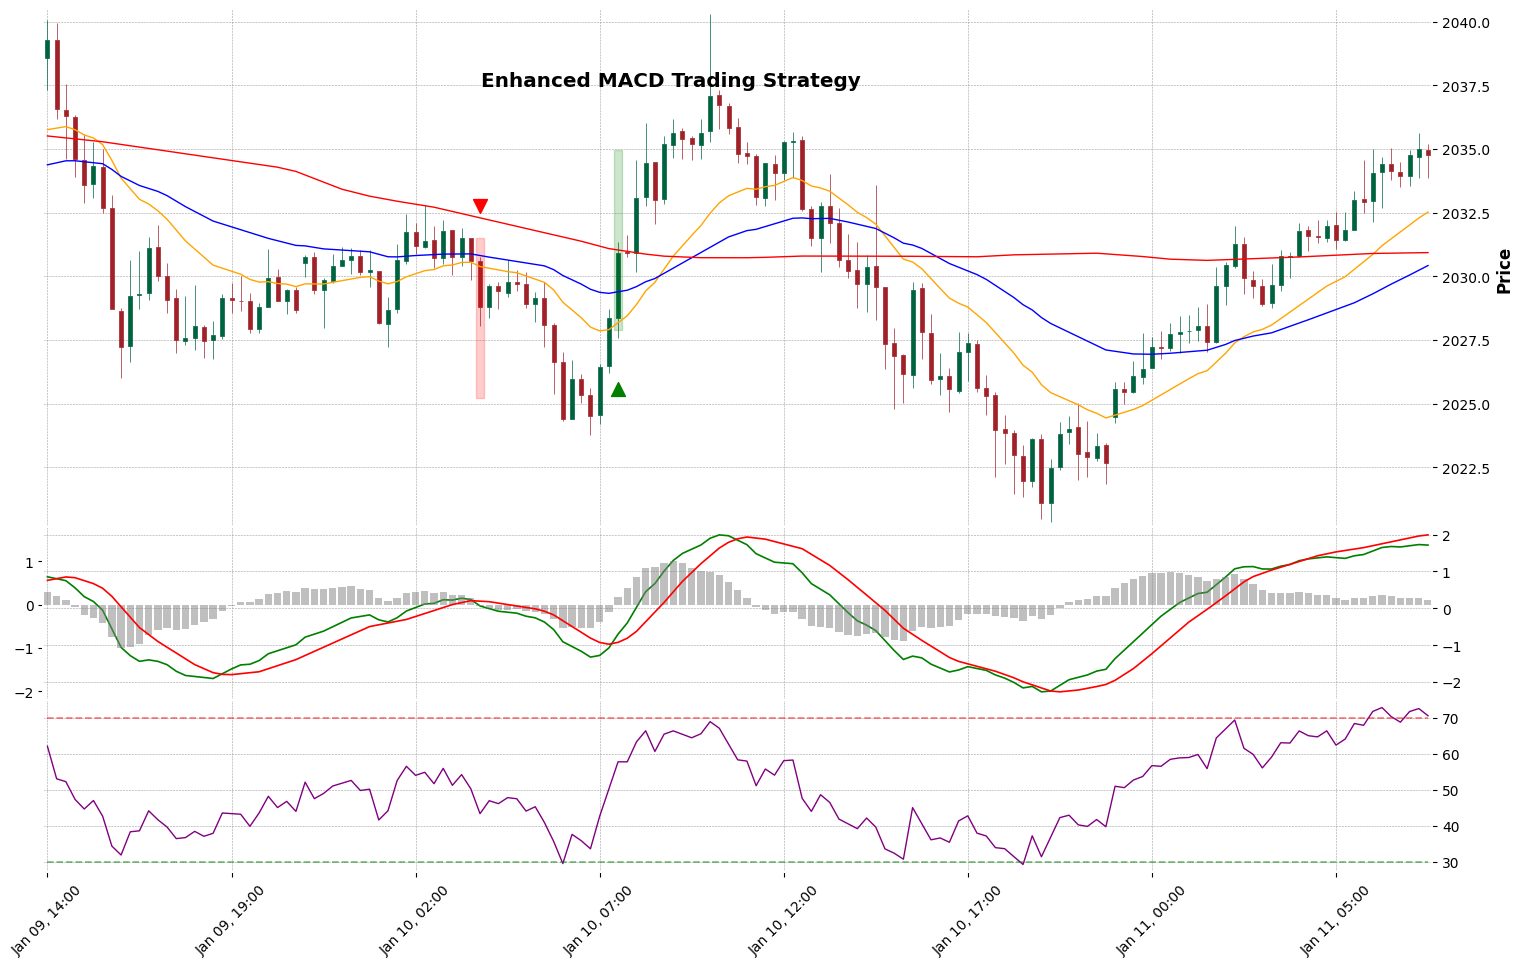

In [25]:
dta = df.iloc[500:651].copy()

fig, axes = plot_enhanced_chart(
    dta,
    show_signals=True,
    show_boxes=True,
    signal_column="Filtered_Crossover"
)
